In [65]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import warnings

warnings.filterwarnings('ignore', module='absl')

# model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1" 
model_url = "https://www.kaggle.com/models/google/hrnet/TensorFlow2/hrnet-camvid-hrnetv2-w48/1" 
model = hub.load(model_url)

In [66]:
import pandas as pd

df = pd.read_csv('class_dict.csv')

df.values.shape

(32, 4)

In [67]:
for name, r, g, b in df.values:
    print(f'name : {name}, r : {r}, g : {g}, b: {b}')

name : Animal, r : 64, g : 128, b: 64
name : Archway, r : 192, g : 0, b: 128
name : Bicyclist, r : 0, g : 128, b: 192
name : Bridge, r : 0, g : 128, b: 64
name : Building, r : 128, g : 0, b: 0
name : Car, r : 64, g : 0, b: 128
name : CartLuggagePram, r : 64, g : 0, b: 192
name : Child, r : 192, g : 128, b: 64
name : Column_Pole, r : 192, g : 192, b: 128
name : Fence, r : 64, g : 64, b: 128
name : LaneMkgsDriv, r : 128, g : 0, b: 192
name : LaneMkgsNonDriv, r : 192, g : 0, b: 64
name : Misc_Text, r : 128, g : 128, b: 64
name : MotorcycleScooter, r : 192, g : 0, b: 192
name : OtherMoving, r : 128, g : 64, b: 64
name : ParkingBlock, r : 64, g : 192, b: 128
name : Pedestrian, r : 64, g : 64, b: 0
name : Road, r : 128, g : 64, b: 128
name : RoadShoulder, r : 128, g : 128, b: 192
name : Sidewalk, r : 0, g : 0, b: 192
name : SignSymbol, r : 192, g : 128, b: 128
name : Sky, r : 128, g : 128, b: 128
name : SUVPickupTruck, r : 64, g : 128, b: 192
name : TrafficCone, r : 0, g : 0, b: 64
name : Tr

In [106]:
import numpy as np

class_dict = {i: k for i, (k, r, g, b) in enumerate(df.values)}
class_colormap = [[r, g, b] for k, r, g, b in df.values]
print(class_colormap[:5])
print(np.array(class_colormap).shape)
print(class_dict)

[[64, 128, 64], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0]]
(32, 3)
{0: 'Animal', 1: 'Archway', 2: 'Bicyclist', 3: 'Bridge', 4: 'Building', 5: 'Car', 6: 'CartLuggagePram', 7: 'Child', 8: 'Column_Pole', 9: 'Fence', 10: 'LaneMkgsDriv', 11: 'LaneMkgsNonDriv', 12: 'Misc_Text', 13: 'MotorcycleScooter', 14: 'OtherMoving', 15: 'ParkingBlock', 16: 'Pedestrian', 17: 'Road', 18: 'RoadShoulder', 19: 'Sidewalk', 20: 'SignSymbol', 21: 'Sky', 22: 'SUVPickupTruck', 23: 'TrafficCone', 24: 'TrafficLight', 25: 'Train', 26: 'Tree', 27: 'Truck_Bus', 28: 'Tunnel', 29: 'VegetationMisc', 30: 'Void', 31: 'Wall'}


In [120]:
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

image_root = os.path.join('images')
label_root = os.path.join('images', 'label')

image_paths = glob.glob('images/*.png')
image_paths

label_paths = glob.glob(f'{label_root}/*.png')

print('images : ', image_paths)
print('labels : ', label_paths)

preds = []
for path in image_paths:
    image = plt.imread(path)
    pred = model.predict(image[np.newaxis])
    preds.append(pred)
    print(pred.shape)



images :  ['images\\0001TP_009600.png', 'images\\0016E5_07987.png', 'images\\Seq05VD_f00240.png']
labels :  ['images\\label\\0001TP_009600.png', 'images\\label\\0016E5_07987.png', 'images\\label\\Seq05VD_f00240.png']
(1, 720, 960, 33)
(1, 720, 960, 33)
(1, 720, 960, 33)


[[26 26 26 ... 26 26 26]
 [26 26 26 ... 26 26 26]
 [26 26 26 ... 26 26 26]
 ...
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]]
(720, 960)
(720, 960)


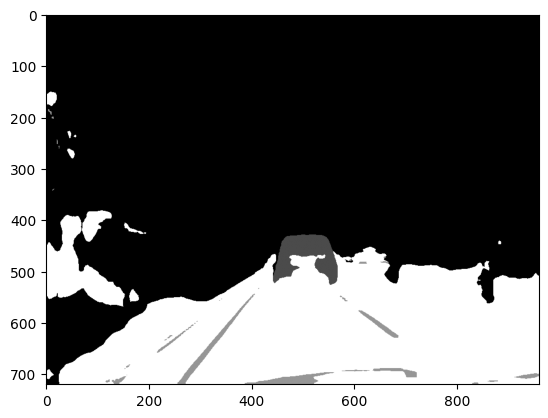

In [143]:
pred = preds[0].numpy()
pred = pred[..., 1:]
pred = np.squeeze(pred)
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask)
mask = np.isin(pred_mask, [5, 10, 17])
print(mask.shape)
pred_mask = pred_mask * mask
print(pred_mask.shape)
plt.imshow(pred_mask, cmap='gray')




In [71]:
type(class_colormap)

list

In [72]:
def display_prediction(image_path, label_path, model):
    image = np.array(plt.imread(image_path))
    label = np.array(plt.imread(label_path))
    pred = model.predict(image[np.newaxis])
    pred = np.squeeze(pred)
    pred = pred[..., 1:]
    
    pred_mask = np.argmax(pred ,axis=-1)
    colormap = np.array(class_colormap)
    pred_mask = colormap[pred_mask]
    
    plt.figure(figsize=(18, 5))
    for i, img in enumerate([image, label, pred_mask]):
        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.axis('off')
    

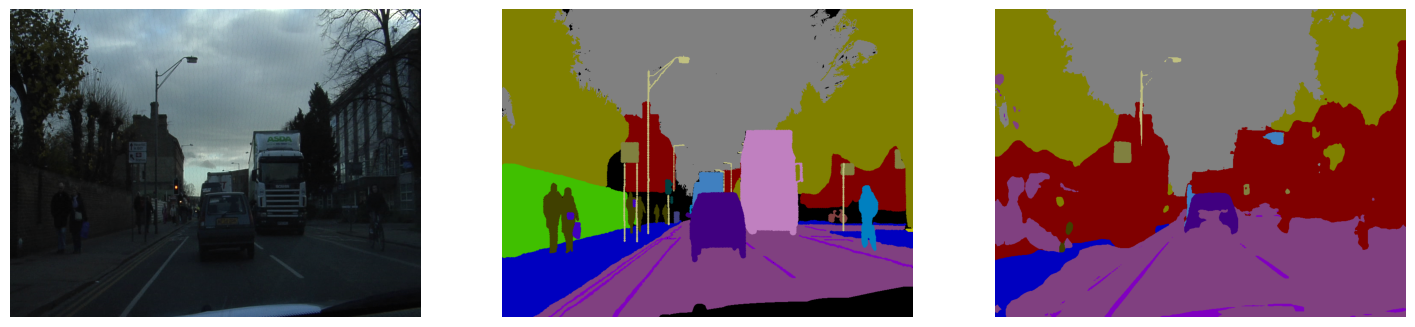

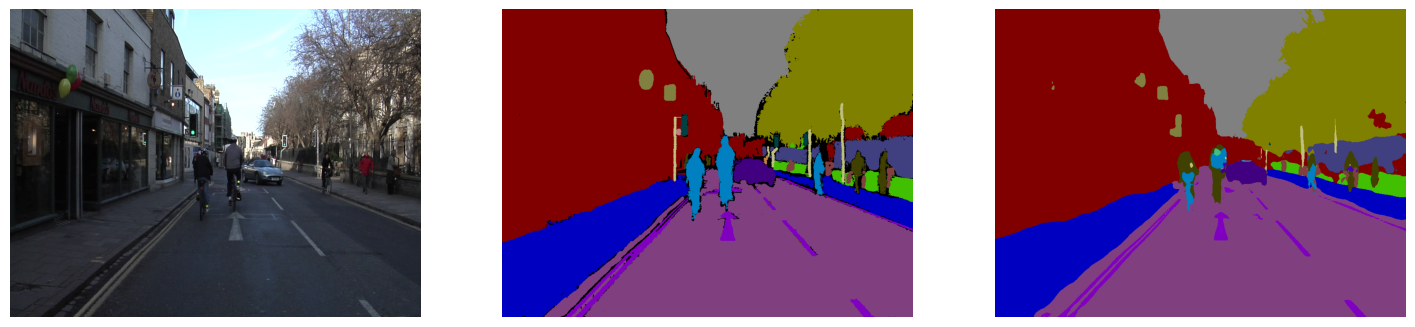

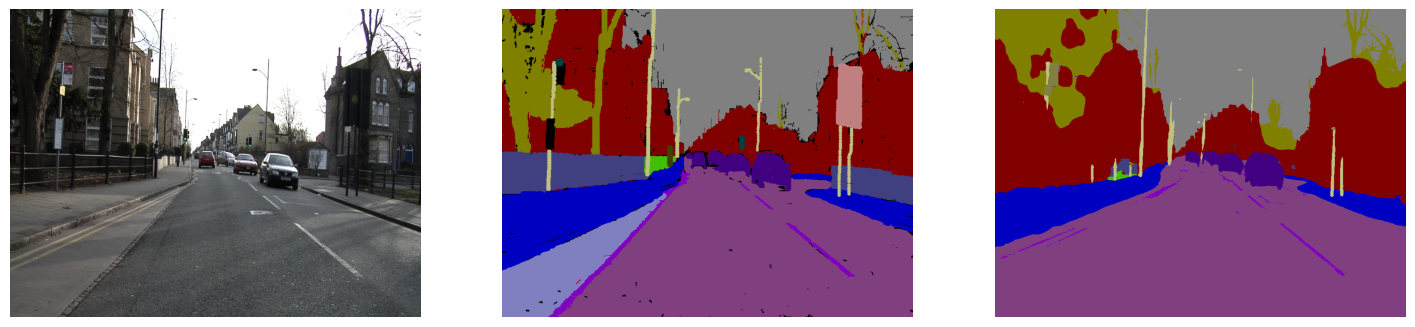

In [73]:
for img_path, label_path in zip(image_paths, label_paths):
    display_prediction(img_path, label_path, model)

In [174]:
import cv2

# 이미지에 마스크 이미지 오버레이
def overlay_img(origin, mask):
    origin = (origin * 255).astype(np.uint8)
    mask = mask.astype(np.uint8)

    alpha = 1.0
    beta = 0.6
    gamma = 0.0
    
    img = cv2.addWeighted(origin, alpha, mask, beta, gamma)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

# 오리지널 이미지와 마스크 클래스 이미지 가져오기
def get_origin_and_mask(path):
    origin = np.array(plt.imread(path))
    pred = model.predict(origin[np.newaxis])
    pred = np.squeeze(pred)
    pred = pred[..., 1:]
    pred_mask_class = np.argmax(pred, axis=-1)
    
    return origin, pred_mask_class

# 클래스 필터링 후 나머지 void 처리
def filter_class(mask_class, list, void=30):
    mask = np.isin(mask_class, list)
    filtered = mask_class * mask
    filtered[filtered == 0] = void
    return filtered

def bbox(mask_class, n_class=32, ignored=[30]):
    print('bbox...')
    print(mask_class)
    boxes = []
    for i in range(n_class):
        if i in ignored:
            continue
        
        yy, xx = np.where(mask_class == i)
        if(len(yy) == 0 or len(xx) == 0):
            continue
        
        print(f'yy : {yy}, xx : {xx}')
        x_min, x_max = xx.min(), xx.max()
        y_min, y_max = yy.min(), yy.max()
        
        boxes.append([(x_min, y_min), (x_max, y_max)])
        
    return boxes

def draw_bbox(img, bbox):
    img_copy = img.copy()
    
    for box in bbox:
        cv2.rectangle(img_copy, box[0], box[1], (0, 255, 0), 1, cv2.LINE_AA)
    
    return img_copy

bbox...
[[30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 ...
 [30 30 30 ... 17 17 17]
 [30 30 30 ... 17 17 17]
 [30 30 30 ... 17 17 17]]
yy : [429 429 429 ... 526 526 526], xx : [497 498 499 ... 553 554 555]
yy : [185 185 186 ... 719 719 719], xx : [  4   5   4 ... 839 840 841]
yy : [151 151 151 ... 719 719 719], xx : [  8   9  10 ... 957 958 959]
bbox...
[[30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 ...
 [30 30 30 ... 17 17 17]
 [30 30 30 ... 17 17 17]
 [30 30 30 ... 17 17 17]]
yy : [353 353 354 ... 412 412 412], xx : [574 575 572 ... 628 629 630]
yy : [404 405 405 ... 719 719 719], xx : [473 472 473 ... 863 864 865]
yy : [366 366 366 ... 719 719 719], xx : [488 489 490 ... 957 958 959]
bbox...
[[30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 ...
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]
yy : [332 332 332 ... 422 422 422], xx : [493 494 495 ... 664 665 666]
yy : [157 1

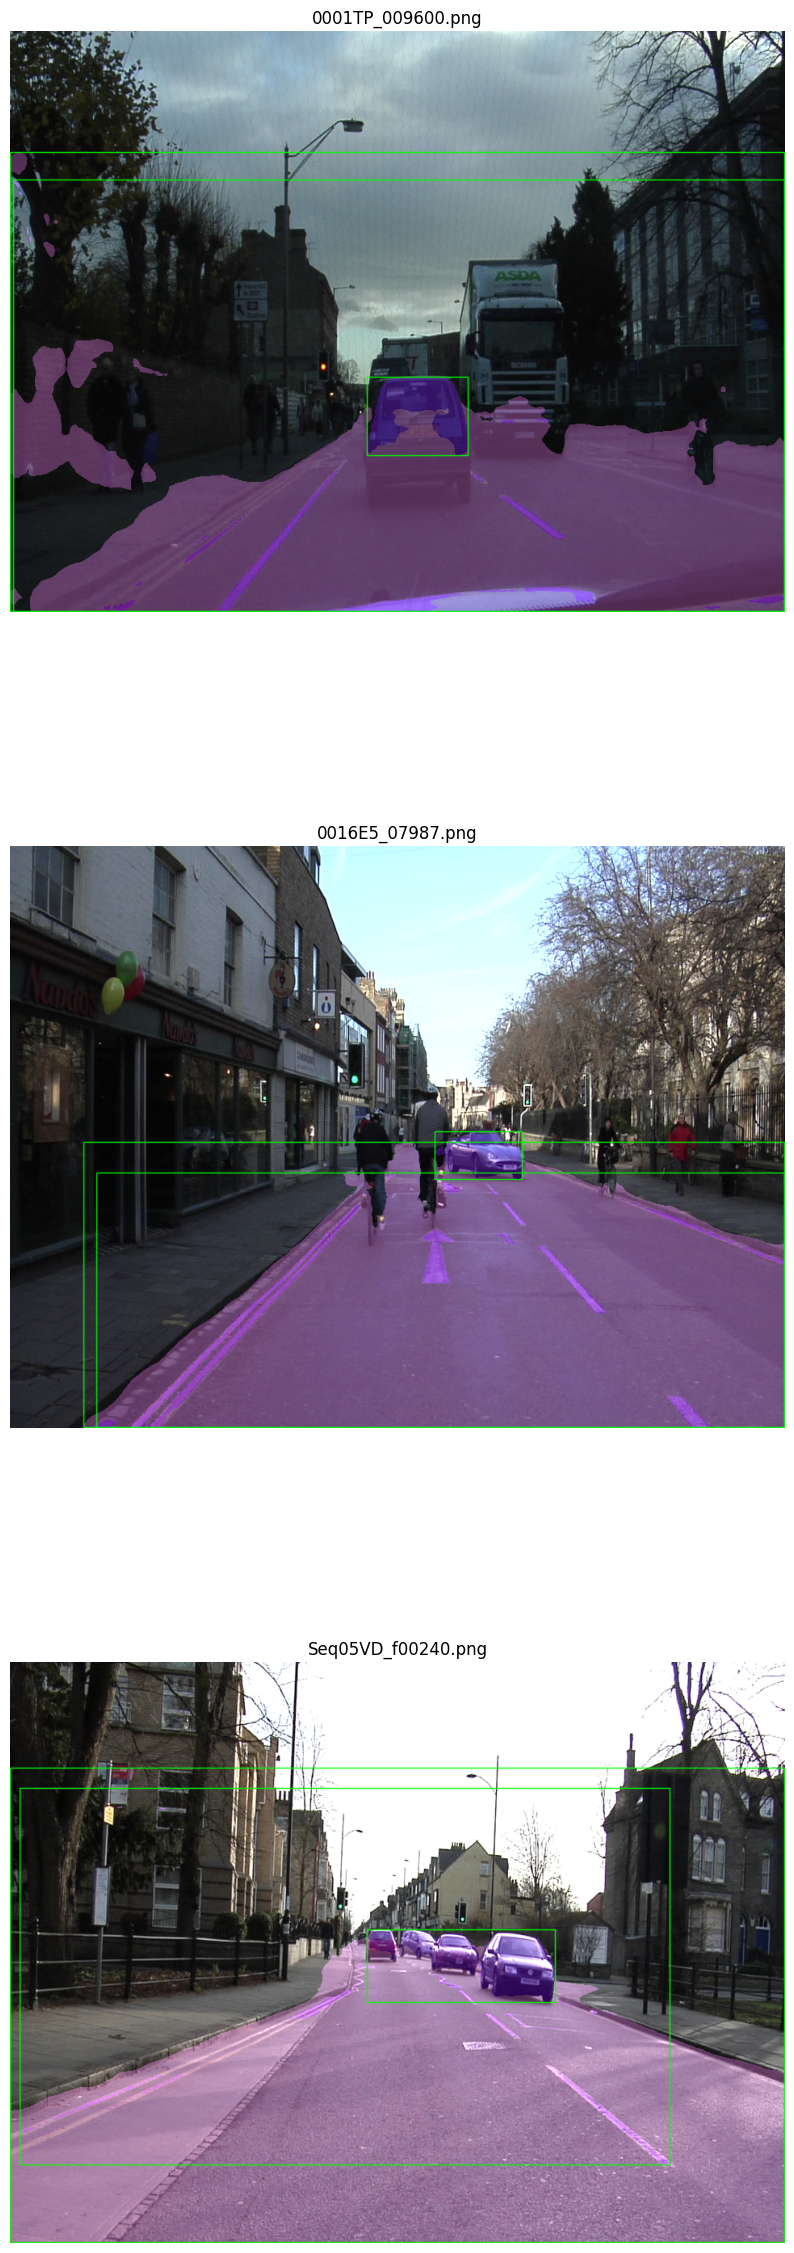

In [176]:
plt.figure(figsize=(10, 30))
for i, img_path in enumerate(image_paths):
    origin, pred_mask_class = get_origin_and_mask(img_path)
    filtered = filter_class(pred_mask_class, [5, 10, 17])
    pred_mask_color = np.array(class_colormap)[filtered]
    overlay = overlay_img(origin, pred_mask_color)
    boxes = bbox(filtered)
    bbox_img = draw_bbox(overlay, boxes)
    plt.subplot(len(image_paths), 1, i+1)
    plt.imshow(bbox_img)
    plt.title(os.path.split(img_path)[1])
    plt.axis('off')
    
    